## This script demonstrates to use minimum code to run a multi-traffic signal control SUMO envorionment. And use IA2C to train a policy, Meixin Zhu
### The enviroment is based on Tianshu Chu's large-grid env.

### First, Run the build_file.py in './envs/large_grid_data/' to generate the SUMO configuration files.

In [1]:
import gym
import numpy as np
from gym.utils import seeding # not used
import time

#### Check SUMO is in System Environment

In [2]:
import os, sys
if 'SUMO_HOME' in os.environ:
	tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
	sys.path.append(tools)
else:
	sys.exit("please declare environment variable 'SUMO_HOME'")

In [3]:
from sumolib import checkBinary 
import traci
# sumoBinary = checkBinary('sumo')
# sumoBinary = checkBinary('sumo-gui')

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

### TrafficLight: an agent with states

Several internal varibles in the TrafficLight class in this script may not be used.

In [5]:
class TrafficLight:
    def __init__(self, name):
        self.name = name
#         self.controlled_lanes = []
        self.state_num = 0  
        self.lanes_in = [] # this lanes comes from traci.trafficlight.getControlledLanes(), which may have duplicated names
        self.ilds_in = [] # this the lanes without duplicated names (a lane may have vehicles heading to different directions)
        self.state = [] # number of vehicles on each lane (ilds)
        
        self.phase_id = -1
        self.prev_action = -1

### Grid Environment

This environment is identical to the large grid env. The phases are hard coded. The SUMO configuration files, including xxx.net.xml, xxx.rou.xml, xxx.sumocfg, etc., are the default files generated by the build_file.py.

In [6]:
PHASE_NUM = 5

class GridEnv(gym.Env):
    def __init__(self, phase_num, gui=False):
        self.phase_num = phase_num
        self.seed()
        self.gui = gui
        self.sim = self._init_sim(self.gui)
        self.nodes, self.node_names = self._init_nodes()
#         self.state_space = None
        self._init_action_space()
        self._init_state_space()
        self.state_approching_vehicle = []
        self.cur_sec = 0
        self.episode_length_sec = 3600

        self.cur_episode = 0
        self.control_interval_sec = 5
        self.yellow_interval_sec = 2
        
        self.phases = ['GGgrrrGGgrrr', 'rrrGrGrrrGrG', 'rrrGGrrrrGGr',
                  'rrrGGGrrrrrr', 'rrrrrrrrrGGG']
        
        
    def seed(self, seed=None):
        """
        Create random seed, useless here as the env is deterministic
        
        Parameters
        ----------
            param seed: the random seed
        """
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    
    def _init_sim(self, gui):
        '''
        Init simulation. The sumo configuration file is the generated file in the envs folder. 
        
        Parameters
        ----------
            gui: indicating whether start the gui
            
        Returns
        -------
            a SUMO traci connection for controlling the simulation env
        '''
        sumoBinary = checkBinary('sumo')
        if gui:
            sumoBinary = checkBinary('sumo-gui')
        traci.start([sumoBinary, "-c", "./envs/large_grid_data/exp.sumocfg"], label='sim1')
        return traci.getConnection("sim1")
    
    
    def _init_nodes(self):
        '''
        Init the nodes (traffic signals)
        
        Parameters
        ----------
            gui: indicating whether start the gui
            
        Returns
        -------
            nodes: a set of TrafficLights
            a sorted list of the names of the nodes
        '''
        nodes = {}
        for node_name in self.sim.trafficlight.getIDList():
            nodes[node_name] = TrafficLight(node_name)
            controlled_lanes = self.sim.trafficlight.getControlledLanes(node_name)
            #print(controlled_lanes)
#             nodes[node_name].controlled_lanes = controlled_lanes 
            ilds_in = []
            for lane_name in controlled_lanes:
                ild_name = lane_name
                if ild_name not in ilds_in:
                    ilds_in.append(ild_name)
            nodes[node_name].ilds_in = ilds_in
#             nodes[node_name].state_num = 
        return nodes, sorted(list(nodes.keys()))
    
    
    def _init_action_space(self):
        self.n_a_ls = []
        for node_name in self.node_names:
            node = self.nodes[node_name]
            node.n_a = self.phase_num
            self.n_a_ls.append(node.n_a)
        self.action_space = np.prod(np.array(self.n_a_ls))
        
        
    def _init_state_space(self):
        self.n_s_ls = [] # a list of number of state of each node
        for node_name in self.node_names:
            node = self.nodes[node_name]
            node.num_state = len(node.ilds_in)
            self.n_s_ls.append(node.num_state)
        self.state_space = np.sum(np.array(self.n_s_ls))
    
    
    def _get_node_action_phase(self, action, node_name, phase_type):
        '''
        Get the node's next phase given an action. 
        
        If the phase_type is green, it returns current phase.
        If the phase_type is yellow, it returns a switching phase, 
        in which the green lanes ('G' or 'g') of the previous phase will be changed into yellow ('y') 
        and the green lanes ('G' or 'g') of the current phase will be changed into red ('r').
        
        Parameters
        ----------
            action: action of the node
            node_name: name of the node
            phase_type: 'green' or 'yellow'
            
        Returns
        -------
            list: a list of strings representing the next phase of the node
        '''
        node = self.nodes[node_name]
        cur_phase = self.phases[int(action)]
        if phase_type == 'green':
            return cur_phase
        prev_action = node.prev_action
        node.prev_action = action
        if (prev_action < 0) or (action == prev_action):
            return cur_phase
        prev_phase = self.phases[int(prev_action)]
        switch_reds = []
        switch_greens = []
        for i, (p0, p1) in enumerate(zip(prev_phase, cur_phase)):
            if (p0 in 'Gg') and (p1 == 'r'):
                switch_reds.append(i)
            elif (p0 in 'r') and (p1 in 'Gg'):
                switch_greens.append(i)
        if not len(switch_reds):
            return cur_phase
        yellow_phase = list(cur_phase)
        for i in switch_reds:
            yellow_phase[i] = 'y'
        for i in switch_greens:
            yellow_phase[i] = 'r'
        return ''.join(yellow_phase)
    
    
    def _set_phase(self, actions, phase_type, phase_duration):
        '''
        set next phases of all nodes given actions
        
        Parameters
        ----------
            actions: action of all nodes
            phase_type: 'green' or 'yellow'
            phase_duration: duration of phase
        '''
        for node_name, action in zip(self.node_names, list(actions)):
            phase = self._get_node_action_phase(action, node_name, phase_type)
            self.sim.trafficlight.setRedYellowGreenState(node_name, phase)
            self.sim.trafficlight.setPhaseDuration(node_name, phase_duration)
    
    
    def _simulate(self, num_step):
        for _ in range(num_step):
            self.sim.simulationStep()
            self.cur_sec += 1
            
            
    def _get_state(self):
        state = []
        for node_name in self.node_names:
            node = self.nodes[node_name]
            cur_state = []
            for ild in node.ilds_in:
                cur_num_vehicle = self.sim.lanearea.getLastStepVehicleNumber(ild)
                cur_state.append(cur_num_vehicle)
            cur_state = np.array(cur_state)
            node.state = cur_state
            state.append(node.state)
        return np.array(state) 
    
    
    def _get_reward_step(self):
        rewards = []
        for node_name in self.node_names:
            queues = []
            for ild in self.nodes[node_name].ilds_in:
                cur_queue = self.sim.lanearea.getLastStepHaltingNumber(ild)
                queues.append(cur_queue)
            queue = np.sum(np.array(queues)) if len(queues) else 0
            reward = - queue
            rewards.append(reward)
        return np.array(rewards)
    
    
    def step(self, action):
        self._set_phase(action, 'yellow', self.yellow_interval_sec)
        self._simulate(self.yellow_interval_sec)
        rest_interval_sec = self.control_interval_sec - self.yellow_interval_sec
        self._set_phase(action, 'green', rest_interval_sec)
        self._simulate(rest_interval_sec)
        state = self._get_state()
        reward = self._get_reward_step()
        done = False
        if self.cur_sec >= self.episode_length_sec:
            done = True
        global_reward = np.sum(reward) # for fair comparison
        return state, reward, done, global_reward
    
    
    def reset(self):
        for node_name in self.node_names:
            node = self.nodes[node_name]
            # prev action for yellow phase before each switch
            node.prev_action = -1 # -1 ?
        self.cur_sec = 0
        self.cur_episode += 1
        return self._get_state()
    
    def terminate(self):
        self.sim.close()

In [7]:
class Policy:
    def __init__(self, node_names, name = 'greedy'):
        self.node_names = node_names
        self.name = 'greedy'

    def forward(self, states):
        actions = []
        for state, node_name in zip(states, self.node_names):
            if self.name == 'greedy':
                action = self.greedy_policy(state)
            else:
                action = self.random_policy(state)
            actions.append(action)
        return actions
    
    def random_policy():
        actions = []
        for node_name in self.node_names:
            action = np.random.randint(5, size= 1)
            actions.append(action)
        actions = np.squeeze(np.array(actions))
        return actions
    
    def greedy_policy(self, ob):
        # hard code the mapping from state to number of cars
        flows = [ob[0] + ob[3], ob[2] + ob[5], ob[1] + ob[4],
                 ob[1] + ob[2], ob[4] + ob[5]]
        actions = np.argmax(np.array(flows))
        return actions

# RL setting

In [8]:
OBS_SIZE = 6 # [vehicles at six lanes]
ACT_SIZE = 5 # NS, EW
batch_size = 120

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, os.path, math, glob, csv, base64, itertools, sys

class ActorNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim = -1)
        return out

class ValueNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, state):
        out = F.relu(self.fc1(state))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

class A2CAgent:
    
    def __init__(self, config):
        self.config = config
        self.gamma = config['gamma']
        self.entropy = config['entropy']
        self.batch_count = 0
        
        # two networks
        self.value_network = ValueNetwork(OBS_SIZE, config['value_network']['hidden_size'], 1)
        self.actor_network = ActorNetwork(OBS_SIZE, config['actor_network']['hidden_size'], ACT_SIZE) 
        
        # two optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr = config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr = config['actor_network']['learning_rate'])
        
        # interaction histories for learning
        self.actions = np.empty((batch_size,), dtype = np.int)
        self.dones = np.empty((batch_size,), dtype = np.bool)
        self.rewards, self.values = np.empty((2, batch_size), dtype = np.float)
        self.observations = np.empty((batch_size,) + (OBS_SIZE,), dtype = np.float)
        
    def _returns_advantages(self, rewards, dones, values, next_value):
        returns = np.append(np.zeros_like(rewards), [next_value], axis = 0)
        
        for t in reversed(range(len(returns)-1)):
            returns[t] = rewards[t] + self.gamma*returns[t + 1]*(1 - dones[t]) # excellent, if finished, then next state is anotehr episode, v(s') = 0
            
        returns = returns[:-1]
        advantages = returns - values 
        return returns, advantages
   
    
    def optimize_model(self, observations, actions, returns, advantages):
        actions = F.one_hot(torch.tensor(actions, dtype = torch.int64), ACT_SIZE)
        returns = torch.tensor(returns[:, None], dtype = torch.float)
        advantages = torch.tensor(advantages, dtype = torch.float)
        observations = torch.tensor(observations, dtype = torch.float)
        
        # MSE for the value network
        self.value_network_optimizer.zero_grad()
        values = self.value_network(observations)
        loss_value = 1*F.mse_loss(values, returns)
        loss_value.backward()
        self.value_network_optimizer.step()
        
        # Actor loss
        self.actor_network_optimizer.zero_grad()
#         logging.info(f'net = {self.actor_network.state_dict()}')
        policies = self.actor_network(observations)
        
        policies = torch.where(policies < 0.0001, torch.tensor(0.0001), policies) # otherwise log(0) = nan
        
        loss_policy = ((actions.float()*policies.log()).sum(-1) * advantages).mean()
        loss_entropy = - (policies*policies.log()).sum(-1).mean()
        loss_actor = - loss_policy - 0.0001 * loss_entropy
        loss_actor.backward()
        self.actor_network_optimizer.step()
        
#         logging.info(f'actions = {actions}')
#         logging.info(f'obs = {observations}')
#         logging.info(f'policies = {policies}')
#         logging.info(f'advantages = {advantages}')
#         logging.info(f'loss_policy = {loss_policy}')
        
        return loss_value, loss_actor


In [9]:
value_learning_rate = 0.001  #@param {type: "number"}
actor_learning_rate = 0.001  #@param {type: "number"}
gamma = 1  #@param {type: "number"}
entropy = 0.0001

config_a2c = {
    'gamma': gamma,
    'value_network': {'learning_rate': value_learning_rate, 'hidden_size': 16},
    'actor_network': {'learning_rate': actor_learning_rate, 'hidden_size': 16},
    'entropy': entropy
}

print("Current config_a2c is:")
print(config_a2c)

Current config_a2c is:
{'gamma': 1, 'value_network': {'learning_rate': 0.001, 'hidden_size': 16}, 'actor_network': {'learning_rate': 0.001, 'hidden_size': 16}, 'entropy': 0.0001}


# RL agents

In [10]:
class Policy:
    def __init__(self, node_names, name = 'greedy'):
        self.node_names = node_names
        self.name = name
        if self.name == 'IA2C':
            self.agents = {}
            for node_name in self.node_names:
                self.agents[node_name] = A2CAgent(config_a2c)

    def forward(self, states):
        actions = []
        for state, node_name in zip(states, self.node_names):
            if self.name == 'greedy':
                action = self.greedy_policy(state)
            elif self.name == 'IA2C':
                action = self.IA2C_policy(state, node_name)
            else:
                action = self.random_policy(state)
            actions.append(action)
        return actions
    
    def random_policy():
        action = np.random.randint(5, size= 1)
        return action
    
    def greedy_policy(self, ob):
        # hard code the mapping from state to number of cars
        flows = [ob[0] + ob[3], ob[2] + ob[5], ob[1] + ob[4],
                 ob[1] + ob[2], ob[4] + ob[5]]
        action = np.argmax(np.array(flows))
        return action
    
    def IA2C_policy(self, ob, node_name):
        a2c = self.agents[node_name]
        policy = a2c.actor_network(torch.tensor(ob, dtype = torch.float))
        #print(policy)
        action = torch.multinomial(policy, 1).detach().numpy()
        return action[0]
        #a2c.actions[a2c.batch_count] = action

In [11]:
# env = GridEnv(phase_num = 5, gui = True)
# policy = Policy(env.node_names, name = 'IA2C')
# rewards = []
# state = env.reset()
# while True:
#     action = policy.forward(state)
#     next_state, _, done, global_reward = env.step(action)
#     rewards.append(global_reward)
#     if done:
#         break
#     state = next_state
# env.terminate()

 Retrying in 1 seconds
Epoch = 0, global reward = -258
Epoch = 1, global reward = -283
Epoch = 2, global reward = -379
Epoch = 3, global reward = -470
Epoch = 4, global reward = -510
 Retrying in 1 seconds
Epoch = 5, global reward = -500
Epoch = 6, global reward = -266
Epoch = 7, global reward = -393
Epoch = 8, global reward = -412
Epoch = 9, global reward = -451
Epoch = 10, global reward = -472
 Retrying in 1 seconds
Epoch = 11, global reward = -505
Epoch = 12, global reward = -295
Epoch = 13, global reward = -362
Epoch = 14, global reward = -421
Epoch = 15, global reward = -467
Epoch = 16, global reward = -426
 Retrying in 1 seconds
Epoch = 17, global reward = -479
Epoch = 18, global reward = -285
Epoch = 19, global reward = -340
Epoch = 20, global reward = -397
Epoch = 21, global reward = -429
Epoch = 22, global reward = -438
 Retrying in 1 seconds
Epoch = 23, global reward = -491
Epoch = 24, global reward = -292
Epoch = 25, global reward = -377
Epoch = 26, global reward = -410
Epoc

Epoch = 220, global reward = -394
 Retrying in 1 seconds
Epoch = 221, global reward = -448
Epoch = 222, global reward = -296
Epoch = 223, global reward = -353
Epoch = 224, global reward = -368
Epoch = 225, global reward = -384
Epoch = 226, global reward = -437
 Retrying in 1 seconds
Epoch = 227, global reward = -445
Epoch = 228, global reward = -288
Epoch = 229, global reward = -324
Epoch = 230, global reward = -372
Epoch = 231, global reward = -388
Epoch = 232, global reward = -397
 Retrying in 1 seconds
Epoch = 233, global reward = -417
Epoch = 234, global reward = -308
Epoch = 235, global reward = -397
Epoch = 236, global reward = -425
Epoch = 237, global reward = -447
Epoch = 238, global reward = -430
 Retrying in 1 seconds
Epoch = 239, global reward = -448
Epoch = 240, global reward = -273
Epoch = 241, global reward = -389
Epoch = 242, global reward = -407
Epoch = 243, global reward = -440
Epoch = 244, global reward = -449
 Retrying in 1 seconds
Epoch = 245, global reward = -439
E

 Retrying in 1 seconds
Epoch = 437, global reward = -505
Epoch = 438, global reward = -335
Epoch = 439, global reward = -361
Epoch = 440, global reward = -421
Epoch = 441, global reward = -429
Epoch = 442, global reward = -442
 Retrying in 1 seconds
Epoch = 443, global reward = -453
Epoch = 444, global reward = -324
Epoch = 445, global reward = -363
Epoch = 446, global reward = -386
Epoch = 447, global reward = -430
Epoch = 448, global reward = -431
 Retrying in 1 seconds
Epoch = 449, global reward = -475
Epoch = 450, global reward = -311
Epoch = 451, global reward = -387
Epoch = 452, global reward = -398
Epoch = 453, global reward = -423
Epoch = 454, global reward = -461
 Retrying in 1 seconds
Epoch = 455, global reward = -501
Epoch = 456, global reward = -302
Epoch = 457, global reward = -366
Epoch = 458, global reward = -406
Epoch = 459, global reward = -421
Epoch = 460, global reward = -438
 Retrying in 1 seconds
Epoch = 461, global reward = -466
Epoch = 462, global reward = -274
E

Epoch = 653, global reward = -502
Epoch = 654, global reward = -303
Epoch = 655, global reward = -381
Epoch = 656, global reward = -374
Epoch = 657, global reward = -382
Epoch = 658, global reward = -421
 Retrying in 1 seconds
Epoch = 659, global reward = -458
Epoch = 660, global reward = -321
Epoch = 661, global reward = -366
Epoch = 662, global reward = -458
Epoch = 663, global reward = -473
Epoch = 664, global reward = -479
 Retrying in 1 seconds
Epoch = 665, global reward = -489
Epoch = 666, global reward = -329
Epoch = 667, global reward = -383
Epoch = 668, global reward = -420
Epoch = 669, global reward = -446
Epoch = 670, global reward = -468
 Retrying in 1 seconds
Epoch = 671, global reward = -498
Epoch = 672, global reward = -298
Epoch = 673, global reward = -410
Epoch = 674, global reward = -420
Epoch = 675, global reward = -451
Epoch = 676, global reward = -515
 Retrying in 1 seconds
Epoch = 677, global reward = -506
Epoch = 678, global reward = -305
Epoch = 679, global rewa

Epoch = 870, global reward = -319
Epoch = 871, global reward = -396
Epoch = 872, global reward = -449
Epoch = 873, global reward = -468
Epoch = 874, global reward = -473
 Retrying in 1 seconds
Epoch = 875, global reward = -519
Epoch = 876, global reward = -318
Epoch = 877, global reward = -416
Epoch = 878, global reward = -437
Epoch = 879, global reward = -415
Epoch = 880, global reward = -457
 Retrying in 1 seconds
Epoch = 881, global reward = -474
Epoch = 882, global reward = -312
Epoch = 883, global reward = -403
Epoch = 884, global reward = -458
Epoch = 885, global reward = -472
Epoch = 886, global reward = -495
 Retrying in 1 seconds
Epoch = 887, global reward = -478
Epoch = 888, global reward = -320
Epoch = 889, global reward = -446
Epoch = 890, global reward = -444
Epoch = 891, global reward = -475
Epoch = 892, global reward = -515
 Retrying in 1 seconds
Epoch = 893, global reward = -499
Epoch = 894, global reward = -324
Epoch = 895, global reward = -384
Epoch = 896, global rewa

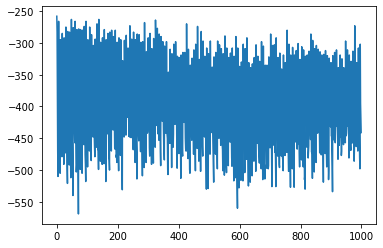

In [12]:
env = GridEnv(phase_num = 5, gui = False)
policy = Policy(env.node_names, name = 'IA2C')
reward_his = []
states = env.reset()
for epoch in range(1000):
    for batch in range(batch_size):
        # choose actions
        actions = policy.forward(states)
        
        # take actions
        next_states, rewards, done, global_reward = env.step(actions)
        
        # recored obs, values, actions, rewards, and dones
        for node_id, node_name in enumerate(env.node_names):
            a2c = policy.agents[node_name]
            obs = states[node_id]
            a2c.observations[batch] = obs
            a2c.values[batch] = a2c.value_network(torch.tensor(obs, dtype=torch.float)).detach().numpy()
            a2c.actions[batch] = actions[node_id]
            a2c.rewards[batch] = global_reward #rewards[node_id], currently using global reward as the signal for single agent
            a2c.dones[batch] = done
            
        states = next_states
        
        if done:
            #env.terminate()
            time.sleep(2)
            sumoBinary = checkBinary('sumo')
            if env.gui:
                sumoBinary = checkBinary('sumo-gui')
            traci.start([sumoBinary, "-c", "./envs/large_grid_data/exp.sumocfg"], label='sim1')
            env.sim = traci.getConnection("sim1")
            states = env.reset()
            
    reward_his.append(global_reward)
    print(f'Epoch = {epoch}, global reward = {global_reward}')
    
    # finished one batch, do network update
    for node_id, node_name in enumerate(env.node_names):
        a2c = policy.agents[node_name]
        
        # calculate next value 
        if done:
            next_value = 0
        else:
            next_value = a2c.value_network(torch.tensor(states[node_id], dtype = torch.float)).detach().numpy()[0]
        
        # calculate returns and advantages
        returns, advantages = a2c._returns_advantages(a2c.rewards, a2c.dones, a2c.values, next_value)

        # learning step
        a2c.optimize_model(a2c.observations, a2c.actions, returns, advantages)

env.terminate()
plt.plot(np.array(reward_his))

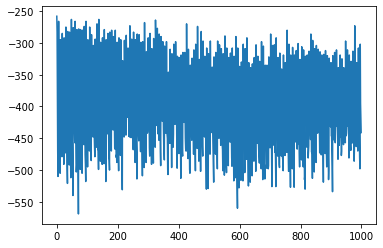

In [13]:
plt.plot(np.array(reward_his))

In [14]:
env = GridEnv(phase_num = 5, gui = True)
policy = Policy(env.node_names, name = 'IA2C')
rewards = []
state = env.reset()
while True:
    action = policy.forward(state)
    next_state, _, done, global_reward = env.step(action)
    rewards.append(global_reward)
    if done:
        break
    state = next_state
env.terminate()
plt.plot(np.array(rewards))

 Retrying in 1 seconds


KeyboardInterrupt: 